# 基于CycleGAN的竹叶字体生成


> 本案例运行需要较大内存，建议在Ascend/GPU上运行。


## 模型介绍

### 模型简介

CycleGAN(Cycle Generative Adversarial Network) 即循环对抗生成网络，来自论文 [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/abs/1703.10593) 。该模型实现了一种在没有配对示例的情况下学习将图像从源域 X 转换到目标域 Y 的方法。

该模型一个重要应用领域是域迁移(Domain Adaptation)，可以通俗地理解为图像风格迁移。其实在 CycleGAN 之前，就已经有了域迁移模型，比如 Pix2Pix ，但是 Pix2Pix 要求训练数据必须是成对的，而现实生活中，要找到两个域（画风）中成对出现的图片是相当困难的，因此 CycleGAN 诞生了，它只需要两种域的数据，而不需要他们有严格对应关系，是一种新的无监督的图像迁移网络。


### 模型结构

CycleGAN 网络本质上是由两个镜像对称的 GAN 网络组成，其结构如下图所示（图片来源于原论文）：

![CycleGAN](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.3.0rc2/tutorials/application/source_zh_cn/generative/images/CycleGAN.png)

为了方便理解，这里以苹果和橘子为例介绍。上图中 $X$ 可以理解为苹果，$Y$ 为橘子；$G$ 为将苹果生成橘子风格的生成器，$F$ 为将橘子生成的苹果风格的生成器，$D_{X}$ 和 $D_{Y}$ 为其相应判别器，具体生成器和判别器的结构可见下文代码。模型最终能够输出两个模型的权重，分别将两种图像的风格进行彼此迁移，生成新的图像。

该模型一个很重要的部分就是损失函数，在所有损失里面循环一致损失(Cycle Consistency Loss)是最重要的。循环损失的计算过程如下图所示（图片来源于原论文）：

![Cycle Consistency Loss](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.3.0rc2/tutorials/application/source_zh_cn/generative/images/CycleGAN_1.png)

图中苹果图片 $x$ 经过生成器 $G$ 得到伪橘子 $\hat{Y}$，然后将伪橘子 $\hat{Y}$ 结果送进生成器 $F$ 又产生苹果风格的结果 $\hat{x}$，最后将生成的苹果风格结果 $\hat{x}$ 与原苹果图片 $x$ 一起计算出循环一致损失，反之亦然。循环损失捕捉了这样的直觉，即如果我们从一个域转换到另一个域，然后再转换回来，我们应该到达我们开始的地方。


## 数据集

本案例为CycleGAN在字体设计方面的衍生使用，使用的数据集分为两组，分别是内容图片，置于TrainA文件夹内；风格图片，置于TrainB文件夹内。通过训练可将TrainB文件夹内图片风格迁移至TrainA内容图片上。TrainA、TrainB文件夹内图片分辨率大小、格式应统一，推荐使用256px，72dpi或512px，72dpi大小的.jpg或.png格式图片。

本案例中，TrainA放置楷体字体png带白底照片，可通过字库解包的python代码获得。TrainB文件夹内放置手动收集与处理的竹叶png带白底图片，通过机器学习的训练，将TrainB文件夹中竹叶的风格迁移至TrainA的楷体字体上，生成风格独特的竹叶字体。

通过OTF或TTF字体库解包，获得需要进行转换的字体图片集。通过裁剪边缘、二值化、重置图片大小等图片处理方法，将字体图片中的文字尽量居中，且在上下左右留出适当的距离。本案例提供楷体文字png图片数据集300张，放置于TrainA文件夹内，数据集概览如下：

![TrainA-dataset](https://mindspore-courses.obs.cn-north-4.myhuaweicloud.com/deep%20learning/AI%2BX/image/20240815-184509.PNG)

通过手动搜集与处理的300张竹叶png图片数据，同样将其进行二值化与重置图片大小，放置于TrainB文件夹内。数据集概览如下：

![TrainB-dataset](https://mindspore-courses.obs.cn-north-4.myhuaweicloud.com/deep%20learning/AI%2BX/image/20240815-184406.PNG)

将TrainA与TrainB文件夹一同放置于根目录下的dataset文件夹内，完成数据集的预处理。

### 数据集下载

使用 `download` 接口下载数据集，并将下载后的数据集自动解压到当前目录下。数据下载之前需要使用 `pip install download` 安装 `download` 包。


In [1]:
##mindspore版本直接使用大模型平台环境里的2.7
##数据集由于下载链接已经失效，手动上传dataset.zip文件，然后解压
!unzip dataset.zip

Archive:  dataset.zip
   creating: trainA/
  inflating: trainA/A (1).png        
  inflating: trainA/A (10).png       
  inflating: trainA/A (100).png      
  inflating: trainA/A (101).png      
  inflating: trainA/A (102).png      
  inflating: trainA/A (103).png      
  inflating: trainA/A (104).png      
  inflating: trainA/A (105).png      
  inflating: trainA/A (106).png      
  inflating: trainA/A (107).png      
  inflating: trainA/A (108).png      
  inflating: trainA/A (109).png      
  inflating: trainA/A (11).png       
  inflating: trainA/A (110).png      
  inflating: trainA/A (111).png      
  inflating: trainA/A (112).png      
  inflating: trainA/A (113).png      
  inflating: trainA/A (114).png      
  inflating: trainA/A (115).png      
  inflating: trainA/A (116).png      
  inflating: trainA/A (117).png      
  inflating: trainA/A (118).png      
  inflating: trainA/A (119).png      
  inflating: trainA/A (12).png       
  inflating: trainA/A (120).png      
  infla

### 指定参数
设置案例所需参数


In [2]:
"""get args."""

import argparse
import ast

parser = argparse.ArgumentParser(description='Cycle GAN')

# basic parameters
parser.add_argument('--platform', type=str, default='Ascend', help='support GPU and Ascend, and CPU')
parser.add_argument('--device_id', type=int, default=0, help='device id, default is 0.')
parser.add_argument('--device_num', type=int, default=1, help='device num, default is 1.')
parser.add_argument('--is_save_on_master', type=int, default=1,
                    help='Save ckpt on master or all rank, 1 for master, 0 for all ranks. Default: 1')
parser.add_argument('--rank', type=int, default=0, help='Local rank of distributed. Default: 0')
parser.add_argument('--group_size', type=int, default=1, help='World size of device. Default: 1')
parser.add_argument('--model', type=str, default='ResNet', choices=('DepthResNet', 'ResNet', 'UNet'), \
                    help='generator model')
parser.add_argument('--init_type', type=str, default='normal', choices=('normal', 'xavier'), \
                    help='network initialization, default is normal.')
parser.add_argument('--init_gain', type=float, default=0.02, \
                    help='scaling factor for normal, xavier and orthogonal, default is 0.02.')
parser.add_argument('--image_size', type=int, default=256, help='input image_size, default is 256.')
parser.add_argument('--batch_size', type=int, default=1, help='batch_size, default is 1.')
parser.add_argument('--pool_size', type=int, default=50, \
                     help='the size of image buffer that stores previously generated images')
parser.add_argument('--beta1', type=float, default=0.5, help='Adam beta1, default is 0.5.')
parser.add_argument('--lr', type=float, default=0.0002, help='learning rate, default is 0.0002.')
parser.add_argument('--lr_policy', type=str, default='linear', choices=('linear', 'constant'), \
                    help='learning rate policy, default is linear')
parser.add_argument('--max_epoch', type=int, default=200, help='epoch size for training, default is 200.')
parser.add_argument('--n_epochs', type=int, default=100, \
                    help='number of epochs with the initial learning rate, default is 100')

# model parameters
parser.add_argument('--in_planes', type=int, default=3, help='input channels, default is 3.')
parser.add_argument('--ngf', type=int, default=64, help='generator model filter numbers, default is 64.')
parser.add_argument('--gl_num', type=int, default=9, help='generator model residual block numbers, default is 9.')
parser.add_argument('--ndf', type=int, default=64, help='discriminator model filter numbers, default is 64.')
parser.add_argument('--dl_num', type=int, default=3, \
                    help='discriminator model residual block numbers, default is 3.')
parser.add_argument('--slope', type=float, default=0.2, help='leakyrelu slope, default is 0.2.')
parser.add_argument('--norm_mode', type=str, default='batch', choices=('batch', 'instance'), \
                    help='norm mode, default is batch.')
parser.add_argument('--lambda_A', type=float, default=10.0, \
                    help='weight for cycle loss (A -> B -> A), default is 10.')
parser.add_argument('--lambda_B', type=float, default=10.0, \
                    help='weight for cycle loss (B -> A -> B), default is 10.')
parser.add_argument('--lambda_idt', type=float, default=0.5, \
                    help='use identity mapping. Setting lambda_identity other than 0 has an effect of scaling the '
                         'weight of the identity mapping loss. For example, if the weight of the identity loss '
                         'should be 10 times smaller than the weight of the reconstruction loss,'
                         'please set lambda_identity = 0.1, default is 0.5.')
parser.add_argument('--gan_mode', type=str, default='lsgan', choices=('lsgan', 'vanilla'), \
                    help='the type of GAN loss, default is lsgan.')
parser.add_argument('--pad_mode', type=str, default='CONSTANT', choices=('CONSTANT', 'REFLECT', 'SYMMETRIC'), \
                    help='the type of Pad, default is CONSTANT.')

# additional parameters
parser.add_argument('--dataroot', default='./data/dataset/', \
                    help='path of images (should have subfolders trainA, trainB, testA, testB, etc).')
parser.add_argument('--data_dir', default='testA', choices=('testA', 'testB'), \
                    help='the translation direction of CycleGAN.')
parser.add_argument('--outputs_dir', type=str, default='./outputs', \
                    help='models are saved here, default is ./outputs.')
parser.add_argument('--load_ckpt', type=ast.literal_eval, default=False, \
                    help='whether load pretrained ckpt')
parser.add_argument('--G_A_ckpt', type=str, default='./outputs/ckpt/G_A_200.ckpt', \
                    help='checkpoint file path of G_A.')
parser.add_argument('--G_B_ckpt', type=str, default='./outputs/ckpt/G_B_200.ckpt', \
                    help='checkpoint file path of G_B.')
parser.add_argument('--D_A_ckpt', type=str, default='./outputs/ckpt/D_A_200.ckpt', \
                    help='checkpoint file path of D_A.')
parser.add_argument('--D_B_ckpt', type=str, default='./outputs/ckpt/D_B_200.ckpt', \
                    help='checkpoint file path of D_B.')
parser.add_argument('--save_checkpoint_epochs', type=int, default=10, \
                    help='Save checkpoint epochs, default is 10.')
parser.add_argument('--print_iter', type=int, default=100, help='log print iter, default is 100.')
parser.add_argument('--need_profiler', type=ast.literal_eval, default=False, \
                    help='whether need profiler, default is False.')
parser.add_argument('--save_graphs', type=ast.literal_eval, default=False, \
                    help='whether save graphs, default is False.')
parser.add_argument('--save_imgs', type=ast.literal_eval, default=True, \
                    help='whether save imgs when epoch end')
parser.add_argument('--save_img_nums', type=int, default=3, \
                    help='Save img nums when epoch end')
parser.add_argument('--use_random', type=ast.literal_eval, default=True, \
                    help='whether use random when training, default is True.')
parser.add_argument('--need_dropout', type=ast.literal_eval, default=False, \
                    help='whether need dropout, default is True.')
parser.add_argument('--max_dataset_size', type=int, default=None, \
                    help='max images pre epoch, default is None.')

# export parameters
parser.add_argument("--export_batch_size", type=int, default=1, \
                    help="batch size")
parser.add_argument("--export_file_name", type=str, default="CycleGAN", \
                    help="output file name.")
parser.add_argument("--export_file_format", type=str, choices=["AIR", "ONNX", "MINDIR"], \
                    default='MINDIR', help="file format")
# args = parser.parse_args()
args = parser.parse_args(args=[]) # run .ipynb use this


def get_args(phase):
    """Define the common options that are used in both training and test."""
    if args.platform == "Ascend":
        args.pad_mode = "CONSTANT"

    if phase != "train" and (args.G_A_ckpt is None or args.G_B_ckpt is None):
        raise ValueError('Must set G_A_ckpt and G_B_ckpt in predict phase!')

    if args.batch_size == 1:
        args.norm_mode = "instance"

    if args.dataroot is None:
        raise ValueError('Must set dataroot!')

    if args.max_dataset_size is None:
        args.max_dataset_size = float("inf")

    args.n_epochs = min(args.max_epoch, args.n_epochs)
    args.n_epochs_decay = args.max_epoch - args.n_epochs
    args.phase = phase
    return args

### 数据集加载

使用 MindSpore 的 `GeneratorDataset` 接口读取和解析数据集。


In [16]:
"""Dataset distributed sampler."""

import math
import numpy as np


class DistributedSampler:
    """Distributed sampler."""
    def __init__(self, dataset_size, num_replicas=None, rank=None, shuffle=True):
        if num_replicas is None:
            print("***********Setting world_size to 1 since it is not passed in ******************")
            num_replicas = 1
        if rank is None:
            print("***********Setting rank to 0 since it is not passed in ******************")
            rank = 0
        self.dataset_size = dataset_size
        self.num_replicas = num_replicas
        self.rank = rank
        self.epoch = 0
        self.num_samples = int(math.ceil(dataset_size * 1.0 / self.num_replicas))
        self.total_size = self.num_samples * self.num_replicas
        self.shuffle = shuffle

    def __iter__(self):
        # deterministically shuffle based on epoch
        if self.shuffle:
            indices = np.random.RandomState(seed=self.epoch).permutation(self.dataset_size)
            # np.array type. number from 0 to len(dataset_size)-1, used as index of dataset
            indices = indices.tolist()
            self.epoch += 1
            # change to list type
        else:
            indices = list(range(self.dataset_size))

        # add extra samples to make it evenly divisible
        indices += indices[:(self.total_size - len(indices))]
        assert len(indices) == self.total_size

        # subsample
        indices = indices[self.rank:self.total_size:self.num_replicas]
        assert len(indices) == self.num_samples

        return iter(indices)

    def __len__(self):
        return self.num_samples


"""Cycle GAN dataset."""

import os
import random
import multiprocessing
import numpy as np
from PIL import Image
import mindspore.dataset as de
import mindspore.dataset.vision as C

IMG_EXTENSIONS = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.tif', '.tiff']

def is_image_file(filename):
    """Judge whether it is a picture."""
    return any(filename.lower().endswith(extension) for extension in IMG_EXTENSIONS)


def make_dataset(dir_path, max_dataset_size=float("inf")):
    """Return image list in dir."""
    images = []
    assert os.path.isdir(dir_path), '%s is not a valid directory' % dir_path

    for root, _, fnames in sorted(os.walk(dir_path)):
        for fname in fnames:
            if is_image_file(fname):
                path = os.path.join(root, fname)
                images.append(path)
    return images[:min(max_dataset_size, len(images))]


class UnalignedDataset:
    """
    This dataset class can load unaligned/unpaired datasets.
    It requires two directories to host training images from domain A '/path/to/data/trainA'
    and from domain B '/path/to/data/trainB' respectively.
    You can train the model with the dataset flag '--dataroot /path/to/data'.
    Similarly, you need to prepare two directories:
    '/path/to/data/testA' and '/path/to/data/testB' during test time.
    Returns:
        Two domain image path list.
    """
    def __init__(self, dataroot, phase, max_dataset_size=float("inf"), use_random=True):
        self.dir_A = os.path.join(dataroot, phase + 'A')
        self.dir_B = os.path.join(dataroot, phase + 'B')

        self.A_paths = sorted(make_dataset(self.dir_A, max_dataset_size))   # load images from '/path/to/data/trainA'
        self.B_paths = sorted(make_dataset(self.dir_B, max_dataset_size))    # load images from '/path/to/data/trainB'
        self.A_size = len(self.A_paths)  # get the size of dataset A
        self.B_size = len(self.B_paths)  # get the size of dataset B
        self.use_random = use_random

    def __getitem__(self, index):
        """Return a data point and its metadata information.

        Parameters:
            index (int)      -- a random integer for data indexing

        Returns a dictionary that contains A, B, A_paths and B_paths
            A (tensor)       -- an image in the input domain
            B (tensor)       -- its corresponding image in the target domain
            A_paths (str)    -- image paths
            B_paths (str)    -- image paths
        """
        index_B = index % self.B_size
        if index % max(self.A_size, self.B_size) == 0 and self.use_random:
            random.shuffle(self.A_paths)
            index_B = random.randint(0, self.B_size - 1)
        A_path = self.A_paths[index % self.A_size]
        B_path = self.B_paths[index_B]
        A_img = np.array(Image.open(A_path).convert('RGB'))
        B_img = np.array(Image.open(B_path).convert('RGB'))

        return A_img, B_img

    def __len__(self):
        """Return the total number of images in the dataset.
        """
        # return max(self.A_size, self.B_size)
        return self.A_size


class ImageFolderDataset:
    """
    This dataset class can load images from image folder.
    Args:
        dataroot (str): Images root directory.
        max_dataset_size (int): Maximum number of return image paths.
    Returns:
        Image path list.
    """
    def __init__(self, dataroot, max_dataset_size=float("inf")):
        self.dataroot = dataroot
        self.paths = sorted(make_dataset(dataroot, max_dataset_size))
        self.size = len(self.paths)

    def __getitem__(self, index):
        img_path = self.paths[index % self.size]
        img = np.array(Image.open(img_path).convert('RGB'))

        return img, os.path.split(img_path)[1]

    def __len__(self):
        """Return the total number of images in the dataset.
        As we have two datasets with potentially different number of images,
        we take a maximum of
        """
        return self.size


def create_dataset(args):
    """
    Create dataset
    This dataset class can load images for train or test.
    Args:
        dataroot (str): Images root directory.
    Returns:
        RGB Image list.
    """
    dataroot = args.dataroot
    phase = args.phase
    batch_size = args.batch_size
    device_num = args.device_num
    rank = args.rank
    shuffle = args.use_random
    max_dataset_size = args.max_dataset_size
    cores = multiprocessing.cpu_count()
    num_parallel_workers = 1
    # num_parallel_workers = min(8, int(cores / device_num))
    image_size = args.image_size
    mean = [0.5 * 255] * 3
    std = [0.5 * 255] * 3
    if phase == "train":
        dataset = UnalignedDataset(dataroot, phase, max_dataset_size=max_dataset_size, use_random=args.use_random)
        distributed_sampler = DistributedSampler(len(dataset), device_num, rank, shuffle=shuffle)
        ds = de.GeneratorDataset(dataset, column_names=["image_A", "image_B"],
                                 sampler=distributed_sampler, num_parallel_workers=num_parallel_workers)
        if args.use_random:
            trans = [
                # C.RandomResizedCrop(image_size, scale=(0.5, 1.0), ratio=(0.75, 1.333)),
                # C.RandomHorizontalFlip(prob=0.5),
                C.RandomResizedCrop(image_size, scale=(1.0, 1.0), ratio=(1.0, 1.0)),
                C.RandomHorizontalFlip(prob=0),
                C.Normalize(mean=mean, std=std),
                C.HWC2CHW()
            ]
        else:
            trans = [
                C.Resize((image_size, image_size)),
                C.Normalize(mean=mean, std=std),
                C.HWC2CHW()
            ]
        ds = ds.map(operations=trans, input_columns=["image_A"], num_parallel_workers=num_parallel_workers)
        ds = ds.map(operations=trans, input_columns=["image_B"], num_parallel_workers=num_parallel_workers)
        ds = ds.batch(batch_size, drop_remainder=True)
    else:
        datadir = os.path.join(dataroot, args.data_dir)
        dataset = ImageFolderDataset(datadir, max_dataset_size=max_dataset_size)
        ds = de.GeneratorDataset(dataset, column_names=["image", "image_name"],
                                 num_parallel_workers=num_parallel_workers)
        trans = [
            C.Resize((image_size, image_size)),
            C.Normalize(mean=mean, std=std),
            C.HWC2CHW()
        ]
        ds = ds.map(operations=trans, input_columns=["image"], num_parallel_workers=num_parallel_workers)
        ds = ds.batch(1, drop_remainder=True)
    args.dataset_size = len(dataset)
    return ds


import mindspore as ms
from mindspore.communication import init, get_rank, get_group_size

args = get_args("train")
args.batch_size = 1
args.dataroot = './'

if args.device_num > 1:
    ms.set_context(mode=ms.GRAPH_MODE, device_target=args.platform, save_graphs=args.save_graphs)
    init()
    ms.reset_auto_parallel_context()
    ms.set_auto_parallel_context(parallel_mode=ms.ParallelMode.DATA_PARALLEL, gradients_mean=True)
    args.rank = get_rank()
    args.group_size = get_group_size()
else:
    ms.set_context(mode=ms.GRAPH_MODE, device_target=args.platform,
                   save_graphs=args.save_graphs, device_id=args.device_id)
    args.rank = 0
    args.device_num = 1

if args.platform == "GPU":
    ms.set_context(enable_graph_kernel=True)
if args.need_profiler:
    from mindspore.profiler.profiling import Profiler
    profiler = Profiler(output_path=args.outputs_dir, is_detail=True, is_show_op_path=True)

ds = create_dataset(args)

### 可视化

通过 `create_dict_iterator` 函数将数据转换成字典迭代器，然后使用 `matplotlib` 模块可视化部分训练数据。

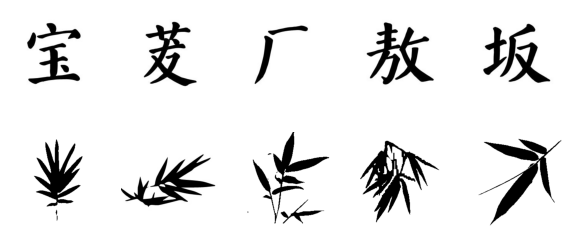

In [17]:
import numpy as np
import matplotlib.pyplot as plt

mean = 0.5 * 255
std = 0.5 * 255

plt.figure(figsize=(12, 5), dpi=60)
for i, data in enumerate(ds.create_dict_iterator()):
    if i < 5:
        show_images_a = data["image_A"].asnumpy()
        show_images_b = data["image_B"].asnumpy()

        plt.subplot(2, 5, i+1)
        show_images_a = (show_images_a[0] * std + mean).astype(np.uint8).transpose((1, 2, 0))
        plt.imshow(show_images_a)
        plt.axis("off")

        plt.subplot(2, 5, i+6)
        show_images_b = (show_images_b[0] * std + mean).astype(np.uint8).transpose((1, 2, 0))
        plt.imshow(show_images_b)
        plt.axis("off")
    else:
        break
plt.show()

## 构建生成器

本案例生成器的模型结构参考的 ResNet 模型的结构，参考原论文，对于128×128大小的输入图片采用6个残差块相连，图片大小为256×256以上的需要采用9个残差块相连，所以本文网络有9个残差块相连，超参数 `n_layers` 参数控制残差块数。

生成器的结构如下所示：

![CycleGAN Generator](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.3.0rc2/tutorials/application/source_zh_cn/generative/images/CycleGAN_2.jpg)

具体的模型结构请参照下文代码：


### 上采样模块

构建`ConvNormReLU`和`ConvTransposeNormReLU`部分

In [18]:
"""Cycle GAN network."""

from mindspore import nn
from mindspore.common.initializer import initializer, Normal, XavierUniform


def init_weights(net, init_type='normal', init_gain=0.02):
    """
    Initialize network weights.
    Parameters:
        net (Cell): Network to be initialized
        init_type (str): The name of an initialization method: normal | xavier.
        init_gain (float): Gain factor for normal and xavier.
    """
    for _, cell in net.cells_and_names():
        if isinstance(cell, (nn.Conv2d, nn.Conv2dTranspose)):
            if init_type == 'normal':
                cell.weight.set_data(initializer(Normal(init_gain), cell.weight.shape, cell.weight.dtype))
            elif init_type == 'xavier':
                cell.weight.set_data(initializer(XavierUniform(init_gain), cell.weight.shape, cell.weight.dtype))
            elif init_type == 'constant':
                cell.weight.set_data(initializer(0.001, cell.weight.shape, cell.weight.dtype))
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
        elif isinstance(cell, nn.BatchNorm2d):
            cell.gamma.set_data(initializer('ones', cell.gamma.shape, cell.gamma.dtype))
            cell.beta.set_data(initializer('zeros', cell.beta.shape, cell.beta.dtype))


class ConvNormReLU(nn.Cell):
    """
    Convolution fused with BatchNorm/InstanceNorm and ReLU/LackyReLU block definition.
    Args:
        in_planes (int): Input channel.
        out_planes (int): Output channel.
        kernel_size (int): Input kernel size. Default: 4.
        stride (int): Stride size for the first convolutional layer. Default: 2.
        alpha (float): Slope of LackyReLU. Default: 0.2.
        norm_mode (str): Specifies norm method. The optional values are "batch", "instance".
        pad_mode (str): Specifies padding mode. The optional values are "CONSTANT", "REFLECT", "SYMMETRIC".
            Default: "CONSTANT".
        use_relu (bool): Use relu or not. Default: True.
        padding (int): Pad size, if it is None, it will calculate by kernel_size. Default: None.
    Returns:
        Tensor, output tensor.
    """
    def __init__(self,
                 in_planes,
                 out_planes,
                 kernel_size=4,
                 stride=2,
                 alpha=0.2,
                 norm_mode='batch',
                 pad_mode='CONSTANT',
                 use_relu=True,
                 padding=None):
        super(ConvNormReLU, self).__init__()
        norm = nn.BatchNorm2d(out_planes)
        if norm_mode == 'instance':
            # Use BatchNorm2d with batchsize=1, affine=False, training=True instead of InstanceNorm2d
            norm = nn.BatchNorm2d(out_planes, affine=False)
        has_bias = (norm_mode == 'instance')
        if padding is None:
            padding = (kernel_size - 1) // 2
        if pad_mode == 'CONSTANT':
            conv = nn.Conv2d(in_planes, out_planes, kernel_size, stride, pad_mode='pad',
                             has_bias=has_bias, padding=padding)
            layers = [conv, norm]
        else:
            paddings = ((0, 0), (0, 0), (padding, padding), (padding, padding))
            pad = nn.Pad(paddings=paddings, mode=pad_mode)
            conv = nn.Conv2d(in_planes, out_planes, kernel_size, stride, pad_mode='pad', has_bias=has_bias)
            layers = [pad, conv, norm]
        if use_relu:
            relu = nn.ReLU()
            if alpha > 0:
                relu = nn.LeakyReLU(alpha)
            layers.append(relu)
        self.features = nn.SequentialCell(layers)

    def construct(self, x):
        output = self.features(x)
        return output


class ConvTransposeNormReLU(nn.Cell):
    """
    ConvTranspose2d fused with BatchNorm/InstanceNorm and ReLU/LackyReLU block definition.
    Args:
        in_planes (int): Input channel.
        out_planes (int): Output channel.
        kernel_size (int): Input kernel size. Default: 4.
        stride (int): Stride size for the first convolutional layer. Default: 2.
        alpha (float): Slope of LackyReLU. Default: 0.2.
        norm_mode (str): Specifies norm method. The optional values are "batch", "instance".
        pad_mode (str): Specifies padding mode. The optional values are "CONSTANT", "REFLECT", "SYMMETRIC".
                        Default: "CONSTANT".
        use_relu (bool): use relu or not. Default: True.
        padding (int): pad size, if it is None, it will calculate by kernel_size. Default: None.
    Returns:
        Tensor, output tensor.
    """
    def __init__(self,
                 in_planes,
                 out_planes,
                 kernel_size=4,
                 stride=2,
                 alpha=0.2,
                 norm_mode='batch',
                 pad_mode='CONSTANT',
                 use_relu=True,
                 padding=None):
        super(ConvTransposeNormReLU, self).__init__()
        conv = nn.Conv2dTranspose(in_planes, out_planes, kernel_size, stride=stride, pad_mode='same')
        norm = nn.BatchNorm2d(out_planes)
        if norm_mode == 'instance':
            # Use BatchNorm2d with batchsize=1, affine=False, training=True instead of InstanceNorm2d
            norm = nn.BatchNorm2d(out_planes, affine=False)
        has_bias = (norm_mode == 'instance')
        if padding is None:
            padding = (kernel_size - 1) // 2
        if pad_mode == 'CONSTANT':
            conv = nn.Conv2dTranspose(in_planes, out_planes, kernel_size, stride, pad_mode='same', has_bias=has_bias)
            layers = [conv, norm]
        else:
            paddings = ((0, 0), (0, 0), (padding, padding), (padding, padding))
            pad = nn.Pad(paddings=paddings, mode=pad_mode)
            conv = nn.Conv2dTranspose(in_planes, out_planes, kernel_size, stride, pad_mode='pad', has_bias=has_bias)
            layers = [pad, conv, norm]
        if use_relu:
            relu = nn.ReLU()
            if alpha > 0:
                relu = nn.LeakyReLU(alpha)
            layers.append(relu)
        self.features = nn.SequentialCell(layers)

    def construct(self, x):
        output = self.features(x)
        return output


### ResNet

构建`ResidualBlock`和`ResNetGenerator`模块

In [19]:
"""ResNet Generator."""

from mindspore import nn
from mindspore import ops


# ResNet
class ResidualBlock1(nn.Cell):
    """
    A resnet block is a conv block with skip connections
    We construct a conv block with build_conv_block function,
    and implement skip connections in <forward> function..
    Args:
        dim (int): Input and output channel.
        norm_mode (str): Specifies norm method. The optional values are "batch", "instance".
        dropout (bool): Use dropout or not. Default: False.
        pad_mode (str): Specifies padding mode. The optional values are "CONSTANT", "REFLECT", "SYMMETRIC".
            Default: "CONSTANT".
    Returns:
        Tensor, output tensor.
    """
    def __init__(self, dim, norm_mode='batch', dropout=False, pad_mode="CONSTANT"):
        super(ResidualBlock1, self).__init__()
        self.conv1 = ConvNormReLU(dim, dim, 3, 1, 0, norm_mode, pad_mode)
        self.conv2 = ConvNormReLU(dim, dim, 3, 1, 0, norm_mode, pad_mode, use_relu=False)
        self.dropout = dropout
        if dropout:
            self.dropout = nn.Dropout(0.5)

    def construct(self, x):
        out = self.conv1(x)
        if self.dropout:
            out = self.dropout(out)
        out = self.conv2(out)
        return x + out


class ResNetGenerator(nn.Cell):
    """
    ResNet Generator of GAN.
    Args:
        in_planes (int): Input channel.
        ngf (int): Output channel.
        n_layers (int): The number of ConvNormReLU blocks.
        alpha (float): LeakyRelu slope. Default: 0.2.
        norm_mode (str): Specifies norm method. The optional values are "batch", "instance".
        dropout (bool): Use dropout or not. Default: False.
        pad_mode (str): Specifies padding mode. The optional values are "CONSTANT", "REFLECT", "SYMMETRIC".
            Default: "CONSTANT".
    Returns:
        Tensor, output tensor.
    """
    def __init__(self, in_planes=3, ngf=64, n_layers=9, alpha=0.2, norm_mode='batch', dropout=False,
                 pad_mode="CONSTANT"):
        super(ResNetGenerator, self).__init__()
        self.conv_in = ConvNormReLU(in_planes, ngf, 7, 1, alpha, norm_mode, pad_mode=pad_mode)
        self.down_1 = ConvNormReLU(ngf, ngf * 2, 3, 2, alpha, norm_mode)
        self.down_2 = ConvNormReLU(ngf * 2, ngf * 4, 3, 2, alpha, norm_mode)
        layers = [ResidualBlock1(ngf * 4, norm_mode, dropout=dropout, pad_mode=pad_mode)] * n_layers
        self.residuals = nn.SequentialCell(layers)
        self.up_2 = ConvTransposeNormReLU(ngf * 4, ngf * 2, 3, 2, alpha, norm_mode)
        self.up_1 = ConvTransposeNormReLU(ngf * 2, ngf, 3, 2, alpha, norm_mode)
        if pad_mode == "CONSTANT":
            self.conv_out = nn.Conv2d(ngf, 3, kernel_size=7, stride=1, pad_mode='pad', padding=3)
        else:
            pad = nn.Pad(paddings=((0, 0), (0, 0), (3, 3), (3, 3)), mode=pad_mode)
            conv = nn.Conv2d(ngf, 3, kernel_size=7, stride=1, pad_mode='pad')
            self.conv_out = nn.SequentialCell([pad, conv])
        self.activate = ops.Tanh()

    def construct(self, x):
        x = self.conv_in(x)
        x = self.down_1(x)
        x = self.down_2(x)
        x = self.residuals(x)
        x = self.up_2(x)
        x = self.up_1(x)
        output = self.conv_out(x)
        return self.activate(output)


### DepthResNet和Unet

生成器的模型结构还可以参考`DepthResNet`和`Unet`的结构

In [20]:

# DepthResNet
class ResidualBlock(nn.Cell):
    """
    ResNet residual block definition.
    We construct a conv block with build_conv_block function,
    and implement skip connections in <forward> function..
    Args:
        dim (int): Input and output channel.
        norm_mode (str): Specifies norm method. The optional values are "batch", "instance".
        dropout (bool): Use dropout or not. Default: False.
        pad_mode (str): Specifies padding mode. The optional values are "CONSTANT", "REFLECT", "SYMMETRIC".
            Default: "CONSTANT".
    Returns:
        Tensor, output tensor.
    """
    def __init__(self, dim, norm_mode='batch', dropout=False, pad_mode="CONSTANT"):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvNormReLU(dim, dim, 3, 1, 0.2, norm_mode, pad_mode)
        self.conv2 = ConvNormReLU(dim, dim, 3, 1, 0.2, norm_mode, pad_mode)
        self.dropout = dropout
        if dropout:
            self.dropout = nn.Dropout(0.5)

    def construct(self, x):
        out = self.conv1(x)
        if self.dropout:
            out = self.dropout(out)
        out = self.conv2(out)
        return x + out


class DepthResNetGenerator(nn.Cell):
    """
    ResNet Generator of GAN.
    Args:
        in_planes (int): Input channel.
        ngf (int): Output channel.
        n_layers (int): The number of ConvNormReLU blocks.
        alpha (float): LeakyRelu slope. Default: 0.2.
        norm_mode (str): Specifies norm method. The optional values are "batch", "instance".
        dropout (bool): Use dropout or not. Default: False.
        pad_mode (str): Specifies padding mode. The optional values are "CONSTANT", "REFLECT", "SYMMETRIC".
            Default: "CONSTANT".
    Returns:
        Tensor, output tensor.
    """
    def __init__(self, in_planes=3, ngf=64, n_layers=9, alpha=0.2, norm_mode='batch', dropout=False,
                 pad_mode="CONSTANT"):
        super(DepthResNetGenerator, self).__init__()
        conv_in1 = nn.Conv2d(in_planes, ngf, kernel_size=3, stride=1, has_bias=True)
        conv_in2 = ConvNormReLU(ngf, ngf, 7, 1, alpha, norm_mode, pad_mode=pad_mode)
        self.conv_in = nn.SequentialCell([conv_in1, conv_in2])
        down_1 = ConvNormReLU(ngf, ngf * 2, 3, 2, alpha, norm_mode)
        Res1 = ResidualBlock(ngf * 2, norm_mode, dropout=dropout, pad_mode=pad_mode)
        self.down_1 = nn.SequentialCell([down_1, Res1])
        down_2 = ConvNormReLU(ngf * 2, ngf * 3, 3, 2, alpha, norm_mode)
        Res2 = ResidualBlock(ngf * 3, norm_mode, dropout=dropout, pad_mode=pad_mode)
        self.down_2 = nn.SequentialCell([down_2, Res2])
        self.down_3 = ConvNormReLU(ngf * 3, ngf * 4, 3, 2, alpha, norm_mode)
        layers = [ResidualBlock(ngf * 4, norm_mode, dropout=dropout, pad_mode=pad_mode)] * (n_layers-5)
        self.residuals = nn.SequentialCell(layers)
        up_3 = ConvTransposeNormReLU(ngf * 4, ngf * 3, 3, 2, alpha, norm_mode)
        Res3 = ResidualBlock(ngf * 3, norm_mode, dropout=dropout, pad_mode=pad_mode)
        self.up_3 = nn.SequentialCell([up_3, Res3])
        up_2 = ConvTransposeNormReLU(ngf * 3, ngf * 2, 3, 2, alpha, norm_mode)
        Res4 = ResidualBlock(ngf * 2, norm_mode, dropout=dropout, pad_mode=pad_mode)
        self.up_2 = nn.SequentialCell([up_2, Res4])
        up_1 = ConvTransposeNormReLU(ngf * 2, ngf, 3, 2, alpha, norm_mode)
        Res5 = ResidualBlock(ngf, norm_mode, dropout=dropout, pad_mode=pad_mode)
        self.up_1 = nn.SequentialCell([up_1, Res5])
        tanh = nn.Tanh()
        if pad_mode == "CONSTANT":
            conv_out1 = nn.Conv2d(ngf, 3, kernel_size=7, stride=1, has_bias=True, pad_mode='pad', padding=3)
            conv_out2 = nn.Conv2d(3, 3, kernel_size=3, stride=1, has_bias=True)
            self.conv_out = nn.SequentialCell([conv_out1, tanh, conv_out2, tanh])
        else:
            pad = nn.Pad(paddings=((0, 0), (0, 0), (3, 3), (3, 3)), mode=pad_mode)
            conv = nn.Conv2d(ngf, 3, kernel_size=7, stride=1, pad_mode='pad')
            self.conv_out = nn.SequentialCell([pad, conv, tanh])

    def construct(self, x):
        """ construct network """
        x = self.conv_in(x)
        x = self.down_1(x)
        x = self.down_2(x)
        x = self.down_3(x)
        x = self.residuals(x)
        x = self.up_3(x)
        x = self.up_2(x)
        x = self.up_1(x)
        output = self.conv_out(x)
        return output


# Unet
class UnetGenerator(nn.Cell):
    """
    Unet-based generator.

    Args:
        in_planes (int): the number of channels in input images.
        out_planes (int): the number of channels in output images.
        ngf (int): the number of filters in the last conv layer.
        n_layers (int): the number of downsamplings in UNet.
        alpha (float): LeakyRelu slope. Default: 0.2.
        norm_mode (str): Specifies norm method. The optional values are "batch", "instance".
        dropout (bool): Use dropout or not. Default: False.

    Returns:
        Tensor, output tensor.
    """
    def __init__(self, in_planes, out_planes, ngf=64, n_layers=7, alpha=0.2, norm_mode='bn', dropout=False):
        super(UnetGenerator, self).__init__()
        # construct unet structure
        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, in_planes=None, submodule=None,
                                             norm_mode=norm_mode, innermost=True)
        for _ in range(n_layers - 5):
            unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, in_planes=None, submodule=unet_block,
                                                 norm_mode=norm_mode, dropout=dropout)
        # gradually reduce the number of filters from ngf * 8 to ngf
        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, in_planes=None, submodule=unet_block,
                                             norm_mode=norm_mode)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, in_planes=None, submodule=unet_block,
                                             norm_mode=norm_mode)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, in_planes=None, submodule=unet_block, norm_mode=norm_mode)
        self.model = UnetSkipConnectionBlock(out_planes, ngf, in_planes=in_planes, submodule=unet_block,
                                             outermost=True, norm_mode=norm_mode)

    def construct(self, x):
        return self.model(x)


class UnetSkipConnectionBlock(nn.Cell):
    """Unet submodule with skip connection.

    Args:
        outer_nc (int): The number of filters in the outer conv layer
        inner_nc (int): The number of filters in the inner conv layer
        in_planes (int): The number of channels in input images/features
        dropout (bool): Use dropout or not. Default: False.
        submodule (Cell): Previously defined submodules
        outermost (bool): If this module is the outermost module
        innermost (bool): If this module is the innermost module
        alpha (float): LeakyRelu slope. Default: 0.2.
        norm_mode (str): Specifies norm method. The optional values are "batch", "instance".

    Returns:
        Tensor, output tensor.
    """
    def __init__(self, outer_nc, inner_nc, in_planes=None, dropout=False,
                 submodule=None, outermost=False, innermost=False, alpha=0.2, norm_mode='batch'):
        super(UnetSkipConnectionBlock, self).__init__()
        downnorm = nn.BatchNorm2d(inner_nc)
        upnorm = nn.BatchNorm2d(outer_nc)
        use_bias = False
        if norm_mode == 'instance':
            downnorm = nn.BatchNorm2d(inner_nc, affine=False)
            upnorm = nn.BatchNorm2d(outer_nc, affine=False)
            use_bias = True
        if in_planes is None:
            in_planes = outer_nc
        downconv = nn.Conv2d(in_planes, inner_nc, kernel_size=4,
                             stride=2, padding=1, has_bias=use_bias, pad_mode='pad')
        downrelu = nn.LeakyReLU(alpha)
        uprelu = nn.ReLU()

        if outermost:
            upconv = nn.Conv2dTranspose(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, pad_mode='pad')
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.Conv2dTranspose(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, has_bias=use_bias, pad_mode='pad')
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.Conv2dTranspose(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, has_bias=use_bias, pad_mode='pad')
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            model = down + [submodule] + up
            if dropout:
                model.append(nn.Dropout(0.5))

        self.model = nn.SequentialCell(model)
        self.skip_connections = not outermost
        self.concat = ops.Concat(axis=1)

    def construct(self, x):
        out = self.model(x)
        if self.skip_connections:
            if x.shape[-1] != out.shape[-1]:
                out = ops.ResizeBilinear(x.shape)(out)
            out = self.concat((out, x))
        return out


### 实例化生成器

通过`model`参数来指定生成器的结构

In [21]:
def get_generator(args):
    """
    This class implements the CycleGAN model, for learning image-to-image translation without paired data.

    The model training requires '--dataset_mode unaligned' dataset.
    By default, it uses a '--netG resnet_9blocks' ResNet generator,
    a '--netD basic' discriminator (PatchGAN introduced by pix2pix),
    and a least-square GANs objective ('--gan_mode lsgan').
    """
    if args.model == "ResNet":
        net = ResNetGenerator(in_planes=args.in_planes, ngf=args.ngf, n_layers=args.gl_num,
                              alpha=args.slope, norm_mode=args.norm_mode, dropout=args.need_dropout,
                              pad_mode=args.pad_mode)
        init_weights(net, args.init_type, args.init_gain)
    elif args.model == "DepthResNet":
        net = DepthResNetGenerator(in_planes=args.in_planes, ngf=args.ngf, n_layers=args.gl_num,
                                   alpha=args.slope, norm_mode=args.norm_mode, dropout=args.need_dropout,
                                   pad_mode=args.pad_mode)
        init_weights(net, args.init_type, args.init_gain)
    elif args.model == "UNet":
        if args.image_size % (2 ** (args.gl_num + 1)) != 0:
            raise ValueError(f"For UNet Generator, the image_size must be a multiple of 2 ** (gl_num + 1), "
                             f"please adjust the image_size or gl_num, now the image_size is {args.image_size} "
                             f"gl_num is {args.gl_num}, it is recommended that gl_num = 7.")
        net = UnetGenerator(in_planes=args.in_planes, out_planes=args.in_planes, ngf=args.ngf, n_layers=args.gl_num,
                            alpha=args.slope, norm_mode=args.norm_mode, dropout=args.need_dropout)
        init_weights(net, args.init_type, args.init_gain)
    else:
        raise NotImplementedError(f'Model {args.model} not recognized.')
    return net

# args = get_args("train")
args.model = "ResNet"

net_rg_a = get_generator(args)
net_rg_a.update_parameters_name('net_rg_a.')

net_rg_b = get_generator(args)
net_rg_b.update_parameters_name('net_rg_b.')

## 构建判别器

判别器其实是一个二分类网络模型，输出判定该图像为真实图的概率。网络模型使用的是 Patch 大小为 70x70 的 PatchGANs 模型。通过一系列的 `Conv2d` 、 `BatchNorm2d` 和 `LeakyReLU` 层对其进行处理，最后通过 Sigmoid 激活函数得到最终概率。


In [22]:
class Discriminator(nn.Cell):
    """
    Discriminator of GAN.
    Args:
        in_planes (int): Input channel.
        ndf (int): Output channel.
        n_layers (int): The number of ConvNormReLU blocks.
        alpha (float): LeakyRelu slope. Default: 0.2.
        norm_mode (str): Specifies norm method. The optional values are "batch", "instance".
    Returns:
        Tensor, output tensor.
    Examples:
        >>> Discriminator(3, 64, 3)
    """
    def __init__(self, in_planes=3, ndf=64, n_layers=3, alpha=0.2, norm_mode='batch'):
        super(Discriminator, self).__init__()
        kernel_size = 4
        layers = [
            nn.Conv2d(in_planes, ndf, kernel_size, 2, pad_mode='pad', padding=1),
            nn.LeakyReLU(alpha)
        ]
        nf_mult = ndf
        for i in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** i, 8) * ndf
            layers.append(ConvNormReLU(nf_mult_prev, nf_mult, kernel_size, 2, alpha, norm_mode, padding=1))
        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8) * ndf
        layers.append(ConvNormReLU(nf_mult_prev, nf_mult, kernel_size, 1, alpha, norm_mode, padding=1))
        layers.append(nn.Conv2d(nf_mult, 1, kernel_size, 1, pad_mode='pad', padding=1))
        self.features = nn.SequentialCell(layers)

    def construct(self, x):
        output = self.features(x)
        return output


def get_discriminator(args):
    """Return discriminator by args."""
    net = Discriminator(in_planes=args.in_planes, ndf=args.ndf, n_layers=args.dl_num,
                        alpha=args.slope, norm_mode=args.norm_mode)
    init_weights(net, args.init_type, args.init_gain)
    return net

net_d_a = get_discriminator(args)
net_d_a.update_parameters_name('net_d_a.')

net_d_b = get_discriminator(args)
net_d_b.update_parameters_name('net_d_b.')

## 优化器和损失函数

根据不同模型需要单独的设置优化器，这是训练过程决定的。

对生成器 $G$ 及其判别器 $D_{Y}$ ，目标损失函数定义为:

$$L_{GAN}(G,D_Y,X,Y)=E_{y-p_{data}(y)}[logD_Y(y)]+E_{x-p_{data}(x)}[log(1-D_Y(G(x)))]$$

其中 $G$ 试图生成看起来与 $Y$ 中的图像相似的图像 $G(x)$ ，而 $D_{Y}$ 的目标是区分翻译样本 $G(x)$ 和真实样本 $y$ ，生成器的目标是最小化这个损失函数以此来对抗判别器。即 $ min_{G} max_{D_{Y}}L_{GAN}(G,D_{Y} ,X,Y )$ 。

单独的对抗损失不能保证所学函数可以将单个输入映射到期望的输出，为了进一步减少可能的映射函数的空间，学习到的映射函数应该是周期一致的，例如对于 $X$ 的每个图像 $x$ ，图像转换周期应能够将 $x$ 带回原始图像，可以称之为正向循环一致性，即 $x→G(x)→F(G(x))\approx x$ 。对于 $Y$ ，类似的 $x→G(x)→F(G(x))\approx x$ 。可以理解采用了一个循环一致性损失来激励这种行为。

循环一致损失函数定义如下：

$$L_{cyc}(G,F)=E_{x-p_{data}(x)}[\Vert F(G(x))-x\Vert_{1}]+E_{y-p_{data}(y)}[\Vert G(F(y))-y\Vert_{1}]$$

循环一致损失能够保证重建图像 $F(G(x))$ 与输入图像 $x$ 紧密匹配。


In [23]:
"""Cycle GAN losses"""

from mindspore import dtype
import mindspore.nn as nn
import mindspore.ops as ops
from mindspore import Tensor


class BCEWithLogits(nn.Cell):
    """
    BCEWithLogits creates a criterion to measure the Binary Cross Entropy between the true labels and
    predicted labels with sigmoid logits.
    Args:
        reduction (str): Specifies the reduction to be applied to the output.
            Its value must be one of 'none', 'mean', 'sum'. Default: 'none'.
    Outputs:
        Tensor or Scalar, if `reduction` is 'none', then output is a tensor and has the same shape as `inputs`.
        Otherwise, the output is a scalar.
    """
    def __init__(self, reduction='mean'):
        super(BCEWithLogits, self).__init__()
        if reduction is None:
            reduction = 'none'
        if reduction not in ('mean', 'sum', 'none'):
            raise ValueError(f"reduction method for {reduction.lower()} is not supported")

        self.loss = ops.SigmoidCrossEntropyWithLogits()
        self.reduce = False
        if reduction == 'sum':
            self.reduce_mode = ops.ReduceSum()
            self.reduce = True
        elif reduction == 'mean':
            self.reduce_mode = ops.ReduceMean()
            self.reduce = True
    def construct(self, predict, target):
        loss = self.loss(predict, target)
        if self.reduce:
            loss = self.reduce_mode(loss)
        return loss

def get_lr(args):
    """
    Learning rate generator.
    For 'linear', we keep the same learning rate for the first <opt.n_epochs> epochs
    and linearly decay the rate to zero over the next <opt.n_epochs_decay> epochs.
    """
    if args.lr_policy == 'linear':
        lrs = [args.lr] * args.dataset_size * args.n_epochs
        lr_epoch = 0
        for epoch in range(args.n_epochs_decay):
            lr_epoch = args.lr * (args.n_epochs_decay - epoch) / args.n_epochs_decay
            lrs += [lr_epoch] * args.dataset_size
        lrs += [lr_epoch] * args.dataset_size * (args.max_epoch - args.n_epochs_decay - args.n_epochs)
        return Tensor(np.array(lrs).astype(np.float32))
    return args.lr

# 构建生成器，判别器优化器
optimizer_rg_a = nn.Adam(net_rg_a.trainable_params(), get_lr(args), beta1=args.beta1)
optimizer_rg_b = nn.Adam(net_rg_b.trainable_params(), get_lr(args), beta1=args.beta1)

optimizer_d_a = nn.Adam(net_d_a.trainable_params(), get_lr(args), beta1=args.beta1)
optimizer_d_b = nn.Adam(net_d_b.trainable_params(), get_lr(args), beta1=args.beta1)

# GAN网络损失函数
def get_loss_fn(args, reduction='mean'):
    loss_fn = None
    if args.gan_mode == "lsgan":
        loss_fn = nn.MSELoss(reduction)
    elif args.gan_mode == "vanilla":
        loss_fn = BCEWithLogits(reduction)
    else:
        raise NotImplementedError(f'GANLoss {mode} not recognized, we support lsgan and vanilla.') 
    return loss_fn

loss_fn = get_loss_fn(args)
l1_loss = nn.L1Loss("mean")

def gan_loss(predict, target):
    target = ops.cast(target, ops.dtype(predict))
    target = ops.ones_like(predict) * target
    loss = loss_fn(predict, target)
    return loss

## 前向计算

搭建模型前向计算损失的过程，过程如下代码。

为了减少模型振荡[1]，这里遵循 Shrivastava 等人的策略[2]，使用生成器生成图像的历史数据而不是生成器生成的最新图像数据来更新鉴别器。这里创建 `ImagePool` 类，保留了一个图像缓冲区，用于存储生成器生成前的50个图像。


In [24]:
def generator(img_a, img_b, use_identity=True):
    fake_a = net_rg_b(img_b)
    fake_b = net_rg_a(img_a)
    rec_a = net_rg_b(fake_b)
    rec_b = net_rg_a(fake_a)
    if use_identity:
        identity_a = net_rg_b(img_a)
        identity_b = net_rg_a(img_b)
    else:
        identity_a = ops.ones_like(img_a)
        identity_b = ops.ones_like(img_b)
    return fake_a, fake_b, rec_a, rec_b, identity_a, identity_b

args.lambda_A = 10.0
args.lambda_B = 10.0
args.lambda_idt = 0.5

def generator_forward(img_a, img_b):
    true = Tensor(True, dtype.bool_)
    fake_a, fake_b, rec_a, rec_b, identity_a, identity_b = generator(img_a, img_b, args.lambda_idt > 0)
    loss_g_a = gan_loss(net_d_b(fake_b), true)
    loss_g_b = gan_loss(net_d_a(fake_a), true)
    loss_c_a = l1_loss(rec_a, img_a) * args.lambda_A
    loss_c_b = l1_loss(rec_b, img_b) * args.lambda_B
    if args.lambda_idt > 0:
        loss_idt_a = l1_loss(identity_a, img_a) * args.lambda_A * args.lambda_idt
        loss_idt_b = l1_loss(identity_b, img_b) * args.lambda_B * args.lambda_idt
    else:
        loss_idt_a = 0
        loss_idt_b = 0
    loss_g = loss_g_a + loss_g_b + loss_c_a + loss_c_b + loss_idt_a + loss_idt_b
    return fake_a, fake_b, loss_g, loss_g_a, loss_g_b, loss_c_a, loss_c_b, loss_idt_a, loss_idt_b

def generator_forward_grad(img_a, img_b):
    _, _, loss_g, _, _, _, _, _, _ = generator_forward(img_a, img_b)
    return loss_g

def discriminator_forward(img_a, img_b, fake_a, fake_b):
    false = Tensor(False, dtype.bool_)
    true = Tensor(True, dtype.bool_)
    d_fake_a = net_d_a(fake_a)
    d_img_a = net_d_a(img_a)
    d_fake_b = net_d_b(fake_b)
    d_img_b = net_d_b(img_b)
    loss_d_a = gan_loss(d_fake_a, false) + gan_loss(d_img_a, true)
    loss_d_b = gan_loss(d_fake_b, false) + gan_loss(d_img_b, true)
    loss_d = (loss_d_a + loss_d_b) * 0.5
    return loss_d

def discriminator_forward_a(img_a, fake_a):
    false = Tensor(False, dtype.bool_)
    true = Tensor(True, dtype.bool_)
    d_fake_a = net_d_a(fake_a)
    d_img_a = net_d_a(img_a)
    loss_d_a = gan_loss(d_fake_a, false) + gan_loss(d_img_a, true)
    return loss_d_a

def discriminator_forward_b(img_b, fake_b):
    false = Tensor(False, dtype.bool_)
    true = Tensor(True, dtype.bool_)
    d_fake_b = net_d_b(fake_b)
    d_img_b = net_d_b(img_b)
    loss_d_b = gan_loss(d_fake_b, false) + gan_loss(d_img_b, true)
    return loss_d_b


class ImagePool():
    """
    This class implements an image buffer that stores previously generated images.
    This buffer enables us to update discriminators using a history of generated images
    rather than the ones produced by the latest generators.
    """
    def __init__(self, pool_size):
        """
        Initialize the ImagePool class
        Args:
            pool_size (int): the size of image buffer, if pool_size=0, no buffer will be created.
        """
        self.pool_size = pool_size
        if self.pool_size > 0:  # create an empty pool
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        """
        Return an image from the pool.
        Args:
            images: the latest generated images from the generator
        Returns images Tensor from the buffer.
        By 50/100, the buffer will return input images.
        By 50/100, the buffer will return images previously stored in the buffer,
        and insert the current images to the buffer.
        """
        if isinstance(images, Tensor):
            images = images.asnumpy()
        if self.pool_size == 0:  # if the buffer size is 0, do nothing
            return Tensor(images)
        return_images = []
        for image in images:
            if self.num_imgs < self.pool_size:   # if the buffer is not full; keep inserting current images to the buffer
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                return_images.append(image)
            else:
                p = random.uniform(0, 1)
                if p > 0.5:  # by 50% chance, the buffer will return a previously stored image, and insert the current image into the buffer
                    random_id = random.randint(0, self.pool_size - 1)  # randint is inclusive
                    tmp = self.images[random_id].copy()
                    self.images[random_id] = image
                    return_images.append(tmp)
                else:       # by another 50% chance, the buffer will return the current image
                    return_images.append(image)
        return_images = np.array(return_images)   # collect all the images and return
        if len(return_images.shape) != 4:
            raise ValueError("img should be 4d, but get shape {}".format(return_images.shape))
        return Tensor(return_images)

## 计算梯度和反向传播

其中梯度计算也是分开不同的模型来进行的，详情见如下代码：

In [25]:
from mindspore import value_and_grad

# 实例化求梯度的方法
grad_g_a = value_and_grad(generator_forward_grad, None, net_rg_a.trainable_params())
grad_g_b = value_and_grad(generator_forward_grad, None, net_rg_b.trainable_params())

grad_d_a = value_and_grad(discriminator_forward_a, None, net_d_a.trainable_params())
grad_d_b = value_and_grad(discriminator_forward_b, None, net_d_b.trainable_params())

# 计算生成器的梯度，反向传播更新参数
def train_step_g(img_a, img_b):
    net_d_a.set_grad(False)
    net_d_b.set_grad(False)
    
    fake_a, fake_b, lg, lga, lgb, lca, lcb, lia, lib = generator_forward(img_a, img_b)
    
    _, grads_g_a = grad_g_a(img_a, img_b)
    _, grads_g_b = grad_g_b(img_a, img_b)
    optimizer_rg_a(grads_g_a)
    optimizer_rg_b(grads_g_b)

    return fake_a, fake_b, lg, lga, lgb, lca, lcb, lia, lib

# 计算判别器的梯度，反向传播更新参数
def train_step_d(img_a, img_b, fake_a, fake_b):
    net_d_a.set_grad(True)
    net_d_b.set_grad(True)

    loss_d_a, grads_d_a = grad_d_a(img_a, fake_a)
    loss_d_b, grads_d_b = grad_d_b(img_b, fake_b)

    loss_d = (loss_d_a + loss_d_b) * 0.5

    optimizer_d_a(grads_d_a)
    optimizer_d_b(grads_d_b)

    return loss_d

## 模型训练

训练分为两个主要部分：训练判别器和训练生成器，在前文的判别器损失函数中，论文采用了最小二乘损失代替负对数似然目标。

- 训练判别器：训练判别器的目的是最大程度地提高判别图像真伪的概率。按照论文的方法需要训练判别器来最小化 $E_{y-p_{data}(y)}[(D(y)-1)^2]$ ；

- 训练生成器：如 CycleGAN 论文所述，我们希望通过最小化 $E_{x-p_{data}(x)}[(D(G(x)-1)^2]$ 来训练生成器，以产生更好的虚假图像。

下面定义了生成器和判别器的训练过程：


### 定义训练过程中用到的工具

创建图片保存、获取学习率、加载权重的函数

In [26]:
from mindspore import load_checkpoint, load_param_into_net


def save_image(img, img_path, random_id=0):
    """Save a numpy image to the disk
    Parameters:
        img (numpy array / Tensor): image to save.
        image_path (str): the path of the image.
        random_id (int): the number range in 0 ~ batch_size to be saved.
    """
    if isinstance(img, Tensor):
        img = img.asnumpy()
    elif not isinstance(img, np.ndarray):
        raise ValueError("img should be Tensor or numpy array, but get {}".format(type(img)))
    img = decode_image(img, random_id)
    img_pil = Image.fromarray(img)
    img_pil.save(img_path)


def decode_image(img, random_id=0):
    """Decode a [1, C, H, W] Tensor to image numpy array."""
    mean = 0.5 * 255
    std = 0.5 * 255
    
    return (img[random_id] * std + mean).astype(np.uint8).transpose((1, 2, 0))


def load_ckpt(args, G_A, G_B, D_A=None, D_B=None):
    """Load parameter from checkpoint."""
    if args.G_A_ckpt is not None:
        param_GA = load_checkpoint(args.G_A_ckpt)
        load_param_into_net(G_A, param_GA)
    if args.G_B_ckpt is not None:
        param_GB = load_checkpoint(args.G_B_ckpt)
        load_param_into_net(G_B, param_GB)
    if D_A is not None and args.D_A_ckpt is not None:
        param_DA = load_checkpoint(args.D_A_ckpt)
        load_param_into_net(D_A, param_DA)
    if D_B is not None and args.D_B_ckpt is not None:
        param_DB = load_checkpoint(args.D_B_ckpt)
        load_param_into_net(D_B, param_DB)


def enable_batch_statistics(net):
    """Enable batch statistics in all BatchNorms"""
    if isinstance(net, nn.BatchNorm2d):
        net.use_batch_statistics = True
    else:
        for cell in net.cells():
            enable_batch_statistics(cell)


### 定义Reporter类

监听训练过程中的数据，打印日志

In [27]:
"""Reporter class."""

import logging
import os
import time
from datetime import datetime
import random
from mindspore import save_checkpoint


class Reporter(logging.Logger):
    """
    This class includes several functions that can save images/checkpoints and print/save logging information.
    Args:
        args (class): Option class.
    """
    def __init__(self, args):
        super(Reporter, self).__init__("cyclegan")
        self.log_dir = os.path.join(args.outputs_dir, 'log')
        self.ckpts_dir = os.path.join(args.outputs_dir, "ckpt")
        self.imgs_dir = os.path.join(args.outputs_dir, "imgs")
        if not os.path.exists(self.log_dir):
            os.makedirs(self.log_dir, exist_ok=True)
        if not os.path.exists(self.ckpts_dir):
            os.makedirs(self.ckpts_dir, exist_ok=True)
        if not os.path.exists(self.imgs_dir):
            os.makedirs(self.imgs_dir, exist_ok=True)
        self.rank = args.rank
        self.save_checkpoint_epochs = args.save_checkpoint_epochs
        self.save_imgs = args.save_imgs
        # console handler
        console = logging.StreamHandler()
        console.setLevel(logging.INFO)
        formatter = logging.Formatter('%(message)s')
        console.setFormatter(formatter)
        self.addHandler(console)
        # file handler
        log_name = datetime.now().strftime('%Y-%m-%d_time_%H_%M_%S') + '_rank_{}.log'.format(self.rank)
        self.log_fn = os.path.join(self.log_dir, log_name)
        fh = logging.FileHandler(self.log_fn)
        fh.setLevel(logging.INFO)
        fh.setFormatter(formatter)
        self.addHandler(fh)
        self.save_args(args)
        self.step = 0
        self.epoch = 0
        self.batch_size = args.batch_size
        self.n_steps = args.dataset_size // args.batch_size
        print(args.dataset_size, self.n_steps)
        self.dataset_size = args.dataset_size // args.device_num
        self.save_img_nums = args.save_img_nums
        self.device_num = args.device_num
        self.print_iter = args.print_iter
        self.G_loss = []
        self.D_loss = []

    def info(self, msg, *args, **kwargs):
        if self.isEnabledFor(logging.INFO):
            self._log(logging.INFO, msg, args, **kwargs)

    def save_args(self, args):
        self.info('Args:')
        args_dict = vars(args)
        for key in args_dict.keys():
            self.info('--> %s: %s', key, args_dict[key])
        self.info('')

    def epoch_start(self):
        self.step_start_time = time.time()
        self.epoch_start_time = time.time()
        self.step = 0
        self.epoch += 1
        self.G_loss = []
        self.D_loss = []

        random.seed()
        self.random_imgs_out_steps = random.sample(range(1, self.n_steps+1), self.save_img_nums)
        
        self.imgs_epoch_dir = os.path.join(self.imgs_dir, str(self.epoch))
        if not os.path.exists(self.imgs_epoch_dir):
            os.makedirs(self.imgs_epoch_dir, exist_ok=True)

    def step_end(self, res_G, res_D):
        """print log when step end."""
        self.step += 1
        loss_D = float(res_D.asnumpy())
        res = []
        for item in res_G[2:]:
            res.append(float(item.asnumpy()))
        self.G_loss.append(res[0])
        self.D_loss.append(loss_D)
        if self.step % self.print_iter == 0:
            step_cost = (time.time() - self.step_start_time) * 1000 / self.print_iter
            losses = "G_loss: {:.2f}, D_loss:{:.2f}, loss_G_A: {:.2f}, loss_G_B: {:.2f}, loss_C_A: {:.2f},"\
                     "loss_C_B: {:.2f}, loss_idt_A: {:.2f}, loss_idt_B：{:.2f}".format(
                         res[0], loss_D, res[1], res[2], res[3], res[4], res[5], res[6])
            self.info("Epoch[{}] [{}/{}] step cost: {:.2f} ms, {}".format(
                self.epoch, self.step, self.dataset_size, step_cost, losses))
            self.step_start_time = time.time()

    def epoch_end(self):
        """print log and save checkpoints when epoch end."""
        epoch_cost = (time.time() - self.epoch_start_time) * 1000
        per_step_time = epoch_cost / self.dataset_size
        mean_loss_G = sum(self.G_loss) / self.dataset_size
        mean_loss_D = sum(self.D_loss) / self.dataset_size
        self.info("Epoch [{}] total cost: {:.2f} ms, per step: {:.2f} ms, G_loss: {:.2f}, D_loss: {:.2f}".format(
            self.epoch, epoch_cost, per_step_time, mean_loss_G, mean_loss_D))

        if self.epoch % self.save_checkpoint_epochs == 0:
            save_checkpoint(net_rg_a, os.path.join(self.ckpts_dir, f"G_A_{self.epoch}.ckpt"))
            save_checkpoint(net_rg_b, os.path.join(self.ckpts_dir, f"G_B_{self.epoch}.ckpt"))
            save_checkpoint(net_d_a, os.path.join(self.ckpts_dir, f"D_A_{self.epoch}.ckpt"))
            save_checkpoint(net_d_b, os.path.join(self.ckpts_dir, f"D_B_{self.epoch}.ckpt"))
            # left latest 20, remove outdated ckpts.
            ckpt_files = [os.path.join(self.ckpts_dir, file) for file in os.listdir(self.ckpts_dir)]
            ckpt_files = sorted(ckpt_files, key=os.path.getmtime)
            if len(ckpt_files) > 20:
                for i in range(len(ckpt_files) - 20):
                    os.remove(ckpt_files[i])

    def visualizer(self, img_A, img_B, fake_A, fake_B):
        # print(self.step, self.random_imgs_out_steps, len(self.random_imgs_out_steps))
        if self.save_imgs and self.step in self.random_imgs_out_steps:
            random.seed()
            random_id = random.randint(0, self.batch_size-1)
            save_image(img_A, os.path.join(self.imgs_epoch_dir, f"{self.epoch}_{self.step}_{random_id}_img_B.png"), random_id)
            save_image(fake_B, os.path.join(self.imgs_epoch_dir, f"{self.epoch}_{self.step}_{random_id}_fake_B.png"), random_id)

    def start_predict(self, direction):
        self.predict_start_time = time.time()
        self.direction = direction
        self.info('==========start predict %s===============', self.direction)

    def end_predict(self):
        cost = (time.time() - self.predict_start_time) * 1000
        per_step_cost = cost / self.dataset_size
        self.info('total {} imgs cost {:.2f} ms, per img cost {:.2f}'.format(self.dataset_size, cost, per_step_cost))
        self.info('==========end predict %s===============\n', self.direction)


### 训练

开始训练模型

In [16]:
import mindspore as ms
import mindspore.nn as nn

ms.set_seed(1)

def train():
    """Train function."""
    args = get_args("train")
    args.model ='ResNet' # 'DepthResNet', 'ResNet', 'UNet' 
    args.platform = 'Ascend'
    args.max_epoch = 100
    args.save_img_nums = 10
    args.outputs_dir = './outputs'

    if args.load_ckpt:
        load_ckpt(args, net_rg_a, net_rg_b, net_d_a, net_d_b)
    
    image_pool_A = ImagePool(args.pool_size)
    image_pool_B = ImagePool(args.pool_size)

    data_loader = ds.create_dict_iterator()
    if args.rank == 0:
        reporter = Reporter(args)
        reporter.info('==========start training===============')
    
    for _ in range(args.max_epoch):
        if args.rank == 0:
            reporter.epoch_start()
        for data in data_loader:
            img_A = data["image_A"]
            img_B = data["image_B"]

            res_G = train_step_g(img_A, img_B)
            fake_A = res_G[0]
            fake_B = res_G[1]
            res_D = train_step_d(img_A, img_B, image_pool_A.query(fake_A), image_pool_B.query(fake_B))

            if args.rank == 0:
                reporter.step_end(res_G, res_D)
                reporter.visualizer(img_A, img_B, fake_A, fake_B)
        if args.rank == 0:
            reporter.epoch_end()
        if args.need_profiler:
            profiler.analyse()
            break
    
    if args.rank == 0:
        reporter.info('==========end training===============')


if __name__ == "__main__":
    train()


Args:
--> platform: Ascend
--> device_id: 0
--> device_num: 1
--> is_save_on_master: 1
--> rank: 0
--> group_size: 1
--> model: ResNet
--> init_type: normal
--> init_gain: 0.02
--> image_size: 256
--> batch_size: 1
--> pool_size: 50
--> beta1: 0.5
--> lr: 0.0002
--> lr_policy: linear
--> max_epoch: 10
--> n_epochs: 100
--> in_planes: 3
--> ngf: 64
--> gl_num: 9
--> ndf: 64
--> dl_num: 3
--> slope: 0.2
--> norm_mode: instance
--> lambda_A: 10.0
--> lambda_B: 10.0
--> lambda_idt: 0.5
--> gan_mode: lsgan
--> pad_mode: CONSTANT
--> dataroot: ./data/dataset/
--> data_dir: testA
--> outputs_dir: ./outputs
--> load_ckpt: False
--> G_A_ckpt: ./outputs/ckpt/G_A_200.ckpt
--> G_B_ckpt: ./outputs/ckpt/G_B_200.ckpt
--> D_A_ckpt: ./outputs/ckpt/D_A_200.ckpt
--> D_B_ckpt: ./outputs/ckpt/D_B_200.ckpt
--> save_checkpoint_epochs: 10
--> print_iter: 100
--> need_profiler: False
--> save_graphs: False
--> save_imgs: True
--> save_img_nums: 10
--> use_random: True
--> need_dropout: False
--> max_dataset_si

300 300


[ERROR] CORE(33858,ffffbab950b0,python):2024-09-09-17:30:46.863.534 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_33858/3499774006.py]
[ERROR] CORE(33858,ffffbab950b0,python):2024-09-09-17:30:46.863.628 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_33858/3499774006.py]


[ERROR] CORE(33858,ffffbab950b0,python):2024-09-09-17:31:15.456.235 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_33858/3499774006.py]
[ERROR] CORE(33858,ffffbab950b0,python):2024-09-09-17:31:15.456.313 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_33858/3499774006.py]
[ERROR] CORE(33858,ffffbab950b0,python):2024-09-09-17:31:17.430.261 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_33858/2447881219.py]


[ERROR] CORE(33858,ffffbab950b0,python):2024-09-09-17:31:23.249.120 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_33858/2447881219.py]
[ERROR] CORE(33858,ffffbab950b0,python):2024-09-09-17:31:31.925.925 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_33858/2723691079.py]
[ERROR] CORE(33858,ffffbab950b0,python):2024-09-09-17:31:31.926.000 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_33858/2723691079.py]
[ERROR] CORE(33858,ffffbab950b0,python):2024-09-09-17:31:31.926.050 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_33858/2723691079.py]
[ERROR] CORE(33858,ffffbab950b0,python):2024-09-09-17:31:31.927.060 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_33858/2723691079.py]
[ERROR] CORE(33858,ffffbab950b0,python):2024-09-09-17:31:31.927.095 [mindspore/c

[ERROR] CORE(33858,ffffbab950b0,python):2024-09-09-17:32:30.280.628 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_33858/2723691079.py]
[ERROR] CORE(33858,ffffbab950b0,python):2024-09-09-17:32:30.280.704 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_33858/2723691079.py]
[ERROR] CORE(33858,ffffbab950b0,python):2024-09-09-17:32:30.280.748 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_33858/2723691079.py]
[ERROR] CORE(33858,ffffbab950b0,python):2024-09-09-17:32:30.281.747 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_33858/2723691079.py]
[ERROR] CORE(33858,ffffbab950b0,python):2024-09-09-17:32:30.281.782 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_33858/2723691079.py]
[ERROR] CORE(33858,ffffbab950b0,python):2024-09-09-17:32:30.281.810 [mindspore/c

[ERROR] CORE(33858,ffffbab950b0,python):2024-09-09-17:33:05.717.102 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_33858/2723691079.py]
[ERROR] CORE(33858,ffffbab950b0,python):2024-09-09-17:33:05.717.179 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_33858/2723691079.py]
[ERROR] CORE(33858,ffffbab950b0,python):2024-09-09-17:33:05.717.214 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_33858/2723691079.py]


[ERROR] CORE(33858,ffffbab950b0,python):2024-09-09-17:33:13.137.725 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_33858/2723691079.py]
[ERROR] CORE(33858,ffffbab950b0,python):2024-09-09-17:33:13.137.798 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_33858/2723691079.py]
[ERROR] CORE(33858,ffffbab950b0,python):2024-09-09-17:33:13.137.830 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_33858/2723691079.py]


Epoch[1] [100/300] step cost: 1704.00 ms, G_loss: 8.69, D_loss:0.26, loss_G_A: 0.50, loss_G_B: 0.72, loss_C_A: 2.70,loss_C_B: 2.28, loss_idt_A: 1.35, loss_idt_B：1.14
Epoch[1] [200/300] step cost: 152.48 ms, G_loss: 10.19, D_loss:0.20, loss_G_A: 0.64, loss_G_B: 0.67, loss_C_A: 2.87,loss_C_B: 3.05, loss_idt_A: 1.43, loss_idt_B：1.53
Epoch[1] [300/300] step cost: 152.81 ms, G_loss: 12.78, D_loss:0.17, loss_G_A: 0.70, loss_G_B: 0.61, loss_C_A: 2.37,loss_C_B: 5.27, loss_idt_A: 1.19, loss_idt_B：2.64
Epoch [1] total cost: 200939.42 ms, per step: 669.80 ms, G_loss: 9.94, D_loss: 0.25
Epoch[2] [100/300] step cost: 152.12 ms, G_loss: 9.63, D_loss:0.22, loss_G_A: 0.72, loss_G_B: 0.31, loss_C_A: 3.24,loss_C_B: 2.49, loss_idt_A: 1.62, loss_idt_B：1.24
Epoch[2] [200/300] step cost: 151.99 ms, G_loss: 7.01, D_loss:0.26, loss_G_A: 0.60, loss_G_B: 0.75, loss_C_A: 1.74,loss_C_B: 2.03, loss_idt_A: 0.87, loss_idt_B：1.02
Epoch[2] [300/300] step cost: 153.33 ms, G_loss: 9.14, D_loss:0.16, loss_G_A: 0.67, loss

## 模型推理

下面我们通过加载生成器网络模型参数文件来对原图进行风格迁移。

推理得到的图片保存在'./outputs/predict'里

In [32]:
"""Cycle GAN test."""
import os
import mindspore as ms
import numpy as np


def predict():
    """Predict function."""
    args = get_args("predict")
    args.platform = 'Ascend'
    args.model = 'ResNet' 
    
    ms.set_context(mode=ms.GRAPH_MODE,
                   device_target=args.platform,
                   save_graphs=args.save_graphs,
                   device_id=args.device_id)
    args.rank = 0
    args.device_num = 1
    if args.platform == "GPU":
        ms.set_context(enable_graph_kernel=True)
    
    args.G_A_ckpt = './outputs/ckpt/G_A_100.ckpt'
    args.G_B_ckpt = './outputs/ckpt/G_B_100.ckpt'
    args.D_A_ckpt = './outputs/ckpt/D_A_100.ckpt'
    args.D_B_ckpt = './outputs/ckpt/D_B_100.ckpt'

    load_ckpt(args, net_rg_a, net_rg_b)

    imgs_out = os.path.join(args.outputs_dir, "predict")
    if not os.path.exists(imgs_out):
        os.makedirs(imgs_out)
    if not os.path.exists(os.path.join(imgs_out, "fake_A")):
        os.makedirs(os.path.join(imgs_out, "fake_A"))
    if not os.path.exists(os.path.join(imgs_out, "fake_B")):
        os.makedirs(os.path.join(imgs_out, "fake_B"))
    
    #args.data_dir = 'testA'
    args.data_dir = 'trainA'
    ds = create_dataset(args)

    reporter = Reporter(args)
    reporter.start_predict("A to B")

    for data in ds.create_dict_iterator(output_numpy=True):
        img_A = ms.Tensor(data["image"])
        path_A = data["image_name"][0]
        if isinstance(path_A, np.bytes_):
            path_A = path_A.decode("UTF-8")
        path_B = path_A[0:-4] + "_fake_B.png"

        fake_B = net_rg_a(img_A)
        save_image(fake_B, os.path.join(imgs_out, "fake_B", path_B))
        save_image(img_A, os.path.join(imgs_out, "fake_B", path_A))
    reporter.info('save fake_B at %s', os.path.join(imgs_out, "fake_B",
                                                    path_A))
    reporter.end_predict()
    
    #args.data_dir = 'testB'
    args.data_dir = 'trainB'
    ds = create_dataset(args)

    reporter.dataset_size = args.dataset_size
    reporter.start_predict("B to A")
    
    for data in ds.create_dict_iterator(output_numpy=True):
        img_B = ms.Tensor(data["image"])
        path_B = data["image_name"][0]
        if isinstance(path_B, np.bytes_):
            path_B = path_B.decode("UTF-8")
        path_A = path_B[0:-4] + "_fake_A.png"
        fake_A = net_rg_b(img_B)
        save_image(fake_A, os.path.join(imgs_out, "fake_A", path_A))
        save_image(img_B, os.path.join(imgs_out, "fake_A", path_B))
    reporter.info('save fake_A at %s', os.path.join(imgs_out, "fake_A",
                                                    path_B))
    reporter.end_predict()


if __name__ == "__main__":
    predict()


Args:
--> platform: Ascend
--> device_id: 0
--> device_num: 1
--> is_save_on_master: 1
--> rank: 0
--> group_size: 1
--> model: ResNet
--> init_type: normal
--> init_gain: 0.02
--> image_size: 256
--> batch_size: 1
--> pool_size: 50
--> beta1: 0.5
--> lr: 0.0002
--> lr_policy: linear
--> max_epoch: 200
--> n_epochs: 100
--> in_planes: 3
--> ngf: 64
--> gl_num: 9
--> ndf: 64
--> dl_num: 3
--> slope: 0.2
--> norm_mode: instance
--> lambda_A: 10.0
--> lambda_B: 10.0
--> lambda_idt: 0.5
--> gan_mode: lsgan
--> pad_mode: CONSTANT
--> dataroot: ./
--> data_dir: trainA
--> outputs_dir: ./outputs
--> load_ckpt: False
--> G_A_ckpt: ./outputs/ckpt/G_A_100.ckpt
--> G_B_ckpt: ./outputs/ckpt/G_B_100.ckpt
--> D_A_ckpt: ./outputs/ckpt/D_A_100.ckpt
--> D_B_ckpt: ./outputs/ckpt/D_B_100.ckpt
--> save_checkpoint_epochs: 10
--> print_iter: 100
--> need_profiler: False
--> save_graphs: False
--> save_imgs: True
--> save_img_nums: 3
--> use_random: True
--> need_dropout: False
--> max_dataset_size: inf
--> 

303 303


save fake_B at ./outputs/predict/fake_B/A (280).png
total 303 imgs cost 6437.21 ms, per img cost 21.24
==========end predict A to B===============

==========start predict B to A===============
save fake_A at ./outputs/predict/fake_A/B (291).png
total 403 imgs cost 7721.61 ms, per img cost 19.16
==========end predict B to A===============



## 模型导出

下面我们通过`mindspore.export`导出MINDIR文件。

In [30]:
"""export file."""

import numpy as np
import mindspore as ms


if __name__ == '__main__':
    args = get_args("export")
    args.G_A_ckpt = './outputs/ckpt/G_A_100.ckpt'
    args.G_B_ckpt = './outputs/ckpt/G_B_100.ckpt'
    args.D_A_ckpt = './outputs/ckpt/D_A_100.ckpt'
    args.D_B_ckpt = './outputs/ckpt/D_B_100.ckpt'
    
    ms.set_context(mode=ms.GRAPH_MODE, device_target=args.platform)
    G_A = get_generator(args)
    G_B = get_generator(args)
    # Use BatchNorm2d with batchsize=1, affine=False, use_batch_statistics=True instead of InstanceNorm2d
    # Use real mean and variance rather than moving_mean and moving_varance in BatchNorm2d
    enable_batch_statistics(G_A)
    enable_batch_statistics(G_B)
    load_ckpt(args, G_A, G_B)

    input_shp = [args.export_batch_size, 3, args.image_size, args.image_size]
    input_array = ms.Tensor(np.random.uniform(-1.0, 1.0, size=input_shp).astype(np.float32))
    G_A_file = f"{args.export_file_name}_AtoB"
    ms.export(G_A, input_array, file_name=G_A_file, file_format=args.export_file_format)
    G_B_file = f"{args.export_file_name}_BtoA"
    ms.export(G_B, input_array, file_name=G_B_file, file_format=args.export_file_format)
